## トレンド、季節周期、自己回帰を状態とする状態空間モデルの構築（pykalman）

In [1]:
%load_ext lab_black

In [2]:
from pathlib import Path
import numpy as np
import pandas as pd
import requests
import io
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import minimize
from pykalman import KalmanFilter

<AxesSubplot:>

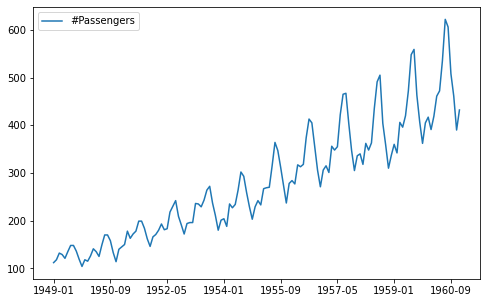

In [3]:
url = "https://www.analyticsvidhya.com/wp-content/uploads/2016/02/AirPassengers.csv"
stream = requests.get(url).content
passengers = pd.read_csv(io.StringIO(stream.decode("utf-8")))

passengers.plot(x="Month", y="#Passengers", figsize=(8, 5), xlabel="")

In [4]:
y = pd.Series(
    passengers["#Passengers"].values,
    index=pd.to_datetime(passengers["Month"], infer_datetime_format=True),
)
y = y.astype(float)

n_train = 120
train_data, test_data = y.values[:n_train], y.values[n_train:]

In [5]:
# 状態空間モデルの構築
def set_state_space_model_matrixes(
    n_dim_trend, n_dim_obs=1, n_dim_series=0, n_dim_ar=0, Q_sigma=10
):

    # 状態全体の次元数を求める
    # 季節周期あるいはARの遷移行列の次元が０ではない場合、それぞれの次元を足したあとに−１
    if n_dim_series > 0 or n_dim_ar > 0:
        n_dim_state = n_dim_trend + n_dim_series + n_dim_ar - 1
    else:
        n_dim_state = n_dim_trend
    n_dim_Q = (n_dim_trend != 0) + (n_dim_series != 0) + (n_dim_ar != 0)

    G = np.zeros((n_dim_state, n_dim_Q))
    F = np.zeros((n_dim_state, n_dim_state))
    H = np.zeros((n_dim_obs, n_dim_state))
    Q = np.eye(n_dim_Q) * Q_sigma

    # トレンドの遷移行列の設定
    F, H, G, index_state, index_obj = set_trend_matrixes(
        F=F, H=H, G=G, n_dim_trend=n_dim_trend
    )

    # 季節周期の遷移行列の設定
    F, H, G, index_state, index_obj = set_series_matrixes(
        F=F,
        H=H,
        G=G,
        n_dim_series=n_dim_series,
        index_state=index_state,
        index_obj=index_obj,
    )

    # ARの遷移行列の設定
    F, H, G, index_state, index_obj = set_ar_matrixes(
        F=F, H=H, G=G, n_dim_ar=n_dim_ar, index_state=index_state, index_obj=index_obj
    )

    Q = G.dot(Q).dot(G.T)

    return F, H, Q, n_dim_state

In [6]:
# トレンドの遷移行列の設定
def set_trend_matrixes(F, H, G, n_dim_trend):

    G[0, 0] = 1
    H[0, 0] = 1
    if n_dim_trend == 1:
        F[0, 0] = 1
    elif n_dim_trend == 2:
        F[0, 0] = 2
        F[0, 1] = -1
        F[1, 0] = 1
    elif n_dim_trend == 3:
        F[0, 0] = 3
        F[0, 1] = -3
        F[0, 2] = 1
        F[1, 0] = 1
        F[2, 1] = 1

    index_state, index_obj = n_dim_trend, n_dim_trend

    return F, H, G, index_state, index_obj

In [7]:
# 季節周期の遷移行列の設定
def set_series_matrixes(F, H, G, n_dim_series, index_state, index_obj):

    if n_dim_series > 0:

        G[index_state, 1] = 1
        H[0, index_obj] = 1

        for i in range(n_dim_series - 1):
            F[index_state, index_state + i] = -1

        for i in range(n_dim_series - 2):
            F[index_state + i + 1, index_state + i] = 1

        index_state = index_state + n_dim_series - 1
        index_obj = index_obj + n_dim_series - 1

    return F, H, G, index_state, index_obj

In [8]:
# ARの遷移行列の設定
def set_ar_matrixes(F, H, G, n_dim_ar, index_state, index_obj):

    if n_dim_ar > 0:

        G[index_state, 2] = 1
        H[0, index_obj] = 1

        for i in range(n_dim_ar):
            F[index_state, index_state + i] = 0

        for i in range(n_dim_ar - 1):
            F[index_state + i + 1, index_state + i] = 1

    return F, H, G, index_state, index_obj

In [9]:
n_dim_obs = 1
n_dim_trend = 2
n_dim_series = 12
n_dim_ar = 2
Q_sigma = 10

# 状態の遷移行列の設定
F, H, Q, n_dim_state = set_state_space_model_matrixes(
    n_dim_trend=n_dim_trend,
    n_dim_obs=n_dim_obs,
    n_dim_series=n_dim_series,
    n_dim_ar=n_dim_ar,
    Q_sigma=Q_sigma,
)

#### トレンド、周期性、ARを状態とする状態空間モデルの構築

In [10]:
kf = KalmanFilter(
    n_dim_obs=n_dim_obs,
    n_dim_state=n_dim_state,
    initial_state_mean=np.zeros(n_dim_state),
    initial_state_covariance=np.ones((n_dim_state, n_dim_state)),
    transition_matrices=F,
    observation_matrices=H,
    observation_covariance=1.0,
    transition_covariance=Q,
)

In [11]:
# 状態空間モデルの予測をグラフ化
def plot_state_space_model_pred(
    kf, y, n_train, credible_interval=True, img_file_path=None
):

    train_data, test_data = y[:n_train], y[n_train:]

    state_means, state_covs = kf.smooth(train_data)
    ovsevation_means_predicted = np.dot(state_means, kf.observation_matrices.T)
    ovsevation_covs_predicted = (
        kf.observation_matrices.dot(np.abs(state_covs))
        .transpose(1, 0, 2)
        .dot(kf.observation_matrices.T)
    )

    lowers, uppers = scipy.stats.norm.interval(
        0.95,
        ovsevation_means_predicted.flatten(),
        scale=np.sqrt(ovsevation_covs_predicted.flatten()),
    )

    current_state = state_means[-1]
    current_cov = state_covs[-1]

    pred_means = np.array([])
    tmp_lowers = []
    tmp_uppers = []
    for i in range(len(test_data)):

        current_state, current_cov = kf.filter_update(
            current_state, current_cov, observation=None
        )
        pred_mean = current_state.dot(kf.observation_matrices.T)
        pred_cov = kf.observation_matrices.dot(np.abs(current_cov)).dot(
            kf.observation_matrices.T
        )

        pred_means = np.r_[pred_means, pred_mean]

        lower, upper = scipy.stats.norm.interval(
            0.95, pred_mean, scale=np.sqrt(pred_cov)
        )
        tmp_lowers.append(lower)
        tmp_uppers.append(upper)

    lowers = np.hstack([lowers, np.array(tmp_lowers).flatten()])
    uppers = np.hstack([uppers, np.array(tmp_uppers).flatten()])

    plt.figure(figsize=(8, 6))
    plt.plot(y, label="observation")
    plt.plot(
        np.hstack([ovsevation_means_predicted.flatten(), pred_means.flatten()]),
        "--",
        label="forecast",
    )
    if credible_interval:
        plt.fill_between(
            range(len(y)), uppers, lowers, alpha=0.5, label="credible interval"
        )
    plt.legend()
    plt.tight_layout()

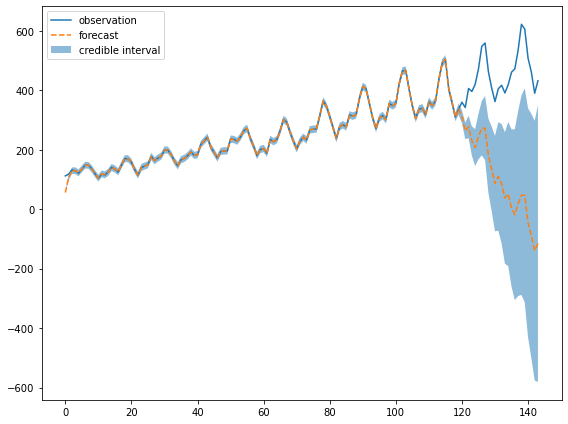

In [12]:
plot_state_space_model_pred(kf=kf, y=y.values, n_train=n_train)

#### 構築した状態空間モデルの状態を分解してグラフ化

In [13]:
# 状態空間モデルの分解した状態をグラフ化
def plot_state_space_model_process(
    kf, y, n_train, n_dim_trend, n_dim_series=0, n_dim_ar=0, img_file_path=None
):

    train_data, test_data = y[:n_train], y[n_train:]

    state_means, state_covs = kf.smooth(train_data)

    # トレンド状態を観測値に変換
    index_start = 0
    index_end = n_dim_trend
    observation_means_predicted_trend = np.dot(
        state_means[:, index_start:index_end],
        kf.observation_matrices[:, index_start:index_end].T,
    )
    index_start = index_end

    if n_dim_series > 0:
        # 季節周期の状態を観測値に変換
        index_end = index_start + n_dim_series - 1
        observation_means_predicted_series = np.dot(
            state_means[:, index_start:index_end],
            kf.observation_matrices[:, index_start:index_end].T,
        )
        index_start = index_end

    if n_dim_ar > 0:
        # ARの状態を観測値に変換
        index_end = index_start + n_dim_ar
        observation_means_predicted_ar = np.dot(
            state_means[:, index_start:index_end],
            kf.observation_matrices[:, index_start:index_end].T,
        )

    pred_means_trend = []
    if n_dim_series > 0:
        pred_means_series = []
    if n_dim_ar > 0:
        pred_means_ar = []

    current_state = state_means[-1]
    current_cov = state_covs[-1]
    for i in range(len(test_data)):

        current_state, current_cov = kf.filter_update(
            current_state, current_cov, observation=None
        )

        index_start = 0
        index_end = n_dim_trend
        pred_means_trend.append(
            kf.observation_matrices[:, index_start:index_end].dot(
                current_state[index_start:index_end]
            )
        )
        index_start = index_end

        if n_dim_series > 0:
            index_end = index_start + n_dim_series - 1
            pred_means_series.append(
                kf.observation_matrices[:, index_start:index_end].dot(
                    current_state[index_start:index_end]
                )
            )
            index_start = index_end

        if n_dim_ar > 0:
            index_end = index_start + n_dim_ar
            pred_means_ar.append(
                kf.observation_matrices[:, index_start:index_end].dot(
                    current_state[index_start:index_end]
                )
            )
            index_start = index_end

    plt.figure(figsize=(8, 6))
    plt.plot(y, label="observation")
    plt.plot(
        np.hstack(
            [
                observation_means_predicted_trend.flatten(),
                np.array(pred_means_trend).flatten(),
            ]
        ),
        "--",
        label="trend",
    )
    if n_dim_series > 0:
        plt.plot(
            np.hstack(
                [
                    observation_means_predicted_series.flatten(),
                    np.array(pred_means_series).flatten(),
                ]
            ),
            ":",
            label="series",
        )
    if n_dim_ar > 0:
        plt.plot(
            np.hstack(
                [
                    observation_means_predicted_ar.flatten(),
                    np.array(pred_means_ar).flatten(),
                ]
            ),
            "+-",
            label="ar",
        )
    plt.legend()
    plt.tight_layout()

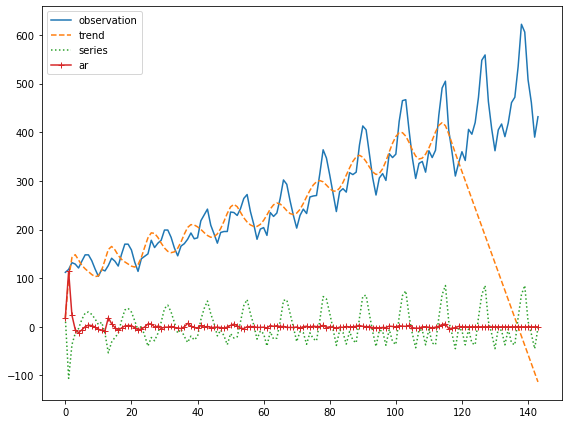

In [14]:
plot_state_space_model_process(
    kf=kf,
    y=y.values,
    n_train=n_train,
    n_dim_trend=n_dim_trend,
    n_dim_series=n_dim_series,
    n_dim_ar=n_dim_ar,
)

#### 遷移行列と共分散の最適化

In [15]:
# 引数の遷移行列を代入し、LogLikelihoodを返す
def minimize_likelihood_state_space_model(
    value, kf, train_data, index_row, index_col, kind="mat"
):

    if kind == "mat":
        kf.transition_matrices[index_row, index_col] = value
    elif kind == "cov":
        kf.transition_covariance[index_row, index_col] = value
    kf.smooth(train_data)

    return -kf.loglikelihood(train_data)

/opt/anaconda3/lib/python3.8/site-packages/pykalman/utils.pyの修正が必要

- 修正前

```php
cv_sol = solve_triangular(cv_chol, (X - mu).T, lower=True).T
```

- 修正後

```php
try:
    cv_sol = solve_triangular(cv_chol, (X - mu).T, lower=True).T
except ValueError:
    cv_sol = np.linalg.solve(cv_chol, (X - mu).T).T
```

In [16]:
n_iter = 5
n_Q = 1 + int(n_dim_series > 0) + int(n_dim_ar > 0)

index_ar_start = n_dim_trend + n_dim_series - 1
bounds_ar = ((-0.95, 0.95),)
bounds_Q = ((1e-4, 1e3),) * (n_Q - 1) + ((1e-4, 5e1),)

kf_copy = copy.deepcopy(kf)
for index_ar in range(n_dim_ar):

    for loop in range(n_iter):

        minimize(
            minimize_likelihood_state_space_model,
            (0.0,),
            args=(
                kf_copy,
                train_data,
                index_ar_start,
                index_ar_start + index_ar,
                "mat",
            ),
            method="SLSQP",
            bounds=bounds_ar,
        )

        cov_indexes = [index_ar_start, n_dim_trend, 0]
        for i, index in enumerate(cov_indexes):

            minimize(
                minimize_likelihood_state_space_model,
                (0.0,),
                args=(kf_copy, train_data, index, index, "cov"),
                method="SLSQP",
                bounds=(bounds_Q[len(cov_indexes) - i - 1],),
            )

        print(
            "AR {} loop [{}/{}], Log Likelifood : {:.2f}".format(
                index_ar + 1, loop + 1, n_iter, kf_copy.loglikelihood(train_data)
            )
        )

opt_kf = copy.deepcopy(kf_copy)

AR 1 loop [1/5], Log Likelifood : -1353.17
AR 1 loop [2/5], Log Likelifood : -1423.14
AR 1 loop [3/5], Log Likelifood : -1423.14
AR 1 loop [4/5], Log Likelifood : -1423.14
AR 1 loop [5/5], Log Likelifood : -1423.14


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


AR 2 loop [1/5], Log Likelifood : -1422.81
AR 2 loop [2/5], Log Likelifood : -1422.45
AR 2 loop [3/5], Log Likelifood : -1422.12
AR 2 loop [4/5], Log Likelifood : -1421.55
AR 2 loop [5/5], Log Likelifood : -1421.13


In [17]:
opt_kf.transition_matrices[index_ar_start:, index_ar_start:]

array([[0.94999998, 0.05856682],
       [1.        , 0.        ]])

In [18]:
np.diag(opt_kf.transition_covariance)[[0, n_dim_trend, index_ar_start]]

array([1.00014901e-04, 1.00000000e+03, 5.00000000e+01])

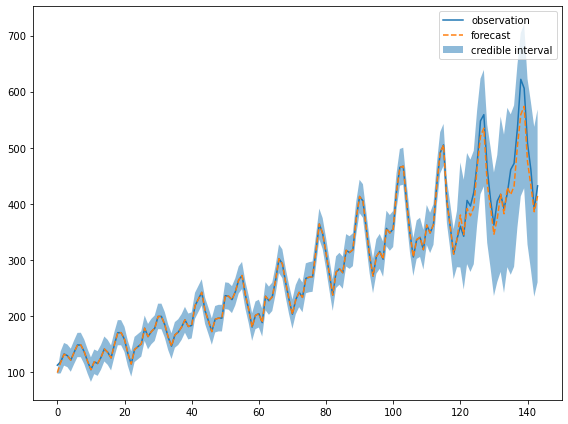

In [19]:
plot_state_space_model_pred(kf=opt_kf, y=y.values, n_train=n_train)

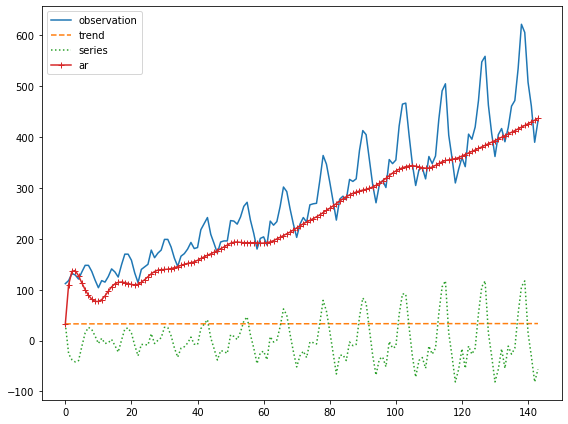

In [20]:
plot_state_space_model_process(
    kf=opt_kf,
    y=y.values,
    n_train=n_train,
    n_dim_trend=n_dim_trend,
    n_dim_series=n_dim_series,
    n_dim_ar=n_dim_ar,
)